In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

url = "https://raw.githubusercontent.com/Kina03/ProjectIs/refs/heads/main/South_Asian_dataset.csv"
df = pd.read_csv(url)

print(df.columns)

Index(['Country', 'Year', 'GDP (current US$)', 'GDP growth (annual %)',
       'GDP per capita (current US$)',
       'Unemployment, total (% of total labor force) (modeled ILO estimate)',
       'Inflation, consumer prices (annual %)',
       'Foreign direct investment, net inflows (% of GDP)', 'Trade (% of GDP)',
       'Gini index', 'Population, total', 'Population growth (annual %)',
       'Poverty headcount ratio at $2.15 a day (2017 PPP) (% of population)',
       'Life expectancy at birth, total (years)',
       'Mortality rate, infant (per 1,000 live births)',
       'Literacy rate, adult total (% of people ages 15 and above)',
       'School enrollment, primary (% gross)',
       'Urban population (% of total population)',
       'Access to electricity (% of population)',
       'People using at least basic drinking water services (% of population)',
       'People using at least basic sanitation services (% of population)',
       'Carbon dioxide (CO2) emissions excluding LU

In [11]:
# แสดงประเทศทั้งหมด
unique_countries = df["Country"].unique()
print("Available countries:", unique_countries)

Available countries: ['Afghanistan' 'Bhutan' 'Bangladesh' 'India' 'Maldives' 'Sri Lanka'
 'Nepal' 'Pakistan']


In [13]:
#เลือกประเทศที่ต้องการ สามารถเปลี่ยนเป็นประเทศที่ต้องการได้
country = "Afghanistan"

#เลือกคอลัมน์ที่จะใช้งาน
df_country = df[df["Country"] == country][["Year", "GDP (current US$)"]]

# ทำความสะอาดข้อมูล
# ลบแถวที่มี NaN
df_country = df_country.dropna()

# ใช้ Interpolation เติมค่าที่หายไป
df_country["GDP (current US$)"] = df_country["GDP (current US$)"].interpolate(method="linear")

# ลบข้อมูลซ้ำ
df_country = df_country.drop_duplicates(subset=["Year"], keep="first")

# ลบค่าที่ผิดปกติ (GDP = 0 หรือ ค่าผิดปกติจาก IQR)
Q1 = df_country["GDP (current US$)"].quantile(0.25)
Q3 = df_country["GDP (current US$)"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_country = df_country[(df_country["GDP (current US$)"] >= lower_bound) & (df_country["GDP (current US$)"] <= upper_bound)]

# ทำ Scaling ข้อมูล GDP
scaler = MinMaxScaler(feature_range=(0, 1))
df_country["GDP_scaled"] = scaler.fit_transform(df_country[["GDP (current US$)"]])


In [14]:
#เตรียมข้อมูลสำหรับ LSTM
SEQ_LENGTH = 3  # ใช้ข้อมูลย้อนหลัง 3 ปี

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i : i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

data = df_country["GDP_scaled"].values
X, y = create_sequences(data, SEQ_LENGTH)

#แบ่ง Train/Test Set
split = int(len(X) * 0.8)  # 80% Train, 20% Test
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

#สร้างโมเดล LSTM
model = Sequential([
    LSTM(50, activation="relu", return_sequences=True, input_shape=(SEQ_LENGTH, 1)),
    LSTM(50, activation="relu"),
    Dense(1)
])

model.compile(optimizer="adam", loss="mse")
print(model.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 3, 50)               │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

None


In [15]:
#เทรนโมเดล
X_train = X_train.reshape(-1, SEQ_LENGTH, 1)
X_test = X_test.reshape(-1, SEQ_LENGTH, 1)

history = model.fit(X_train, y_train, epochs=100, batch_size=8, validation_data=(X_test, y_test))


Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 513ms/step - loss: 0.4847 - val_loss: 0.6601
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.5201 - val_loss: 0.6356
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.4906 - val_loss: 0.6152
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.4265 - val_loss: 0.5978
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.5340 - val_loss: 0.5808
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.4324 - val_loss: 0.5643
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.5152 - val_loss: 0.5478
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.4232 - val_loss: 0.5311
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.3553 - val_loss: 0.5144
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.3412 - val_loss: 0.4965
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.4157 - val_loss: 0.4771
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.3926 - val_l

In [16]:
# ทำนาย GDP ปี 2030
future_years = list(range(df_country["Year"].max() + 1, 2031))
future_gdp_scaled = []

# ใช้ข้อมูลล่าสุดเป็นจุดเริ่มต้น
last_sequence = X[-1].reshape(1, SEQ_LENGTH, 1)

for year in future_years:
    next_gdp_scaled = model.predict(last_sequence)[0][0]
    future_gdp_scaled.append(next_gdp_scaled)

    # อัปเดต sequence โดยเลื่อนข้อมูล
    last_sequence = np.roll(last_sequence, -1)
    last_sequence[0, -1, 0] = next_gdp_scaled

#แปลงค่ากลับเป็น GDP จริง
future_gdp_actual = scaler.inverse_transform(np.array(future_gdp_scaled).reshape(-1, 1)).flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Predicted GDP for 2030:
   Year  Predicted GDP
0  2023   1.911659e+10
1  2024   1.871421e+10
2  2025   1.765464e+10
3  2026   1.948787e+10
4  2027   1.929262e+10
5  2028   1.936084e+10
6  2029   2.015902e+10
7  2030   2.022803e+10


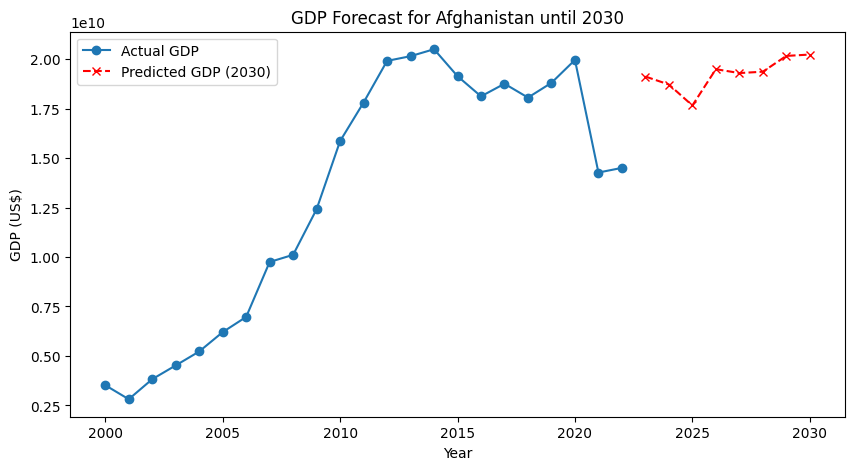

In [17]:
#ผลลัพธ์
print("Predicted GDP for 2030:")
print(pd.DataFrame({"Year": future_years, "Predicted GDP": future_gdp_actual}))

plt.figure(figsize=(10,5))
plt.plot(df_country["Year"], df_country["GDP (current US$)"], label="Actual GDP", marker="o")
plt.plot(future_years, future_gdp_actual, label="Predicted GDP (2030)", marker="x", linestyle="dashed", color="red")
plt.xlabel("Year")
plt.ylabel("GDP (US$)")
plt.legend()
plt.title(f"GDP Forecast for {country} until 2030")
plt.show()
